In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evalution
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import tensorflow as tf

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
#data = pd.read_csv('/content/drive/MyDrive/Datasets/metro data.csv')
#data

path = '/content/drive/MyDrive/datoscsv/'

#data = pd.read_csv(path + 'airWeather_2013-2019_v3.csv', sep=';', index_col='FECHA', parse_dates=['FECHA'])
data = pd.read_csv(path + 'airWeather_2013-2019_v3.csv', sep=';')

# seleccionar solo una estación
data = data[data['COD_ESTACION']==46250043]

# eliminar campos no necesarios
data = data.drop(['COD_ESTACION', 'NOM_ESTACION', 'SO2', 'PM10', 'PM2.5', 'lluvias', 'VelocVent'], axis=1)

# eliminar filas que tengan algun valor nulo
data = data.dropna()



data

,FECHA,NO,NO2,NOx,O3,Temp
0,2013-01-01,5.0,30.0,39.0,27.0,13.70
1,2013-01-02,83.0,85.0,211.0,16.0,11.40
122,2013-05-03,8.0,31.0,43.0,44.0,16.00
123,2013-05-04,13.0,30.0,50.0,45.0,16.50
124,2013-05-05,11.0,29.0,45.0,47.0,17.10
...,...,...,...,...,...,...
2551,2019-12-27,21.0,42.0,74.0,12.0,13.55
2552,2019-12-28,19.0,40.0,69.0,16.0,10.55
2553,2019-12-29,3.0,27.0,32.0,27.0,11.75
2554,2019-12-30,23.0,45.0,81.0,17.0,9.90


In [135]:
#data.holiday.unique()

In [136]:
plt.figure(figsize=(16,9))
fig = px.line(data, x=data.FECHA, y='O3', title='valor de O3 with slider')
fig.update_xaxes(rangeslider_visible=True)
fig.show() 


<Figure size 1152x648 with 0 Axes>

In [137]:
data.describe()

,NO,NO2,NOx,O3,Temp
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,9.158766,25.430233,38.964669,51.070662,18.955434
std,11.584504,14.977539,30.816656,21.577568,5.493438
min,0.000000,2.000000,4.000000,3.000000,6.000000
25%,3.000000,14.000000,18.000000,35.000000,14.150000
50%,5.000000,22.000000,30.000000,53.000000,18.725000
75%,11.000000,34.000000,50.000000,67.000000,23.800000
max,99.000000,92.000000,211.000000,115.000000,32.150000


In [138]:
data.drop_duplicates(subset=['FECHA'], keep=False,inplace=True)
data.drop(['FECHA'],axis=1,inplace=True)

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2236 entries, 0 to 2555
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO      2236 non-null   float64
 1   NO2     2236 non-null   float64
 2   NOx     2236 non-null   float64
 3   O3      2236 non-null   float64
 4   Temp    2236 non-null   float64
dtypes: float64(5)
memory usage: 104.8 KB


In [140]:
data.columns

Index(['NO', 'NO2', 'NOx', 'O3', 'Temp'], dtype='object')

In [141]:
data.select_dtypes('object').columns

Index([], dtype='object')

In [142]:
# no es necesario, no hay campos categóricos

"""for i in data.select_dtypes('object').columns:
  le = LabelEncoder().fit(data[i])
  data[i] = le.transform(data[i])"""

"for i in data.select_dtypes('object').columns:\n  le = LabelEncoder().fit(data[i])\n  data[i] = le.transform(data[i])"

In [143]:
data

,NO,NO2,NOx,O3,Temp
0,5.0,30.0,39.0,27.0,13.70
1,83.0,85.0,211.0,16.0,11.40
122,8.0,31.0,43.0,44.0,16.00
123,13.0,30.0,50.0,45.0,16.50
124,11.0,29.0,45.0,47.0,17.10
...,...,...,...,...,...
2551,21.0,42.0,74.0,12.0,13.55
2552,19.0,40.0,69.0,16.0,10.55
2553,3.0,27.0,32.0,27.0,11.75
2554,23.0,45.0,81.0,17.0,9.90


In [144]:
validate = data[['NO', 'NO2', 'NOx', 'O3', 'Temp'
       ]].tail(10)
data.drop(data.tail(10).index,inplace=True)

In [145]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [148]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[['NO', 'NO2', 'NOx', 'O3', 'Temp'
       ]])
Y_data = Y_scaler.fit_transform(data[['O3']])

In [149]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = int(len(data)*0.80)
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [150]:
x_train

array([[[0.05050505, 0.31111111, 0.16908213, 0.21428571, 0.29445507],
        [0.83838384, 0.92222222, 1.        , 0.11607143, 0.20650096],
        [0.08080808, 0.32222222, 0.1884058 , 0.36607143, 0.38240918],
        ...,
        [0.1010101 , 0.13333333, 0.12077295, 0.41964286, 0.73996176],
        [0.04040404, 0.07777778, 0.04830918, 0.48214286, 0.81835564],
        [0.07070707, 0.03333333, 0.0531401 , 0.53571429, 0.77820268]],

       [[0.83838384, 0.92222222, 1.        , 0.11607143, 0.20650096],
        [0.08080808, 0.32222222, 0.1884058 , 0.36607143, 0.38240918],
        [0.13131313, 0.31111111, 0.22222222, 0.375     , 0.40152964],
        ...,
        [0.04040404, 0.07777778, 0.04830918, 0.48214286, 0.81835564],
        [0.07070707, 0.03333333, 0.0531401 , 0.53571429, 0.77820268],
        [0.08080808, 0.12222222, 0.10144928, 0.47321429, 0.76099426]],

       [[0.08080808, 0.32222222, 0.1884058 , 0.36607143, 0.38240918],
        [0.13131313, 0.31111111, 0.22222222, 0.375     , 0.4

In [151]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

Multiple window of past history

[[0.05050505 0.31111111 0.16908213 0.21428571 0.29445507]
 [0.83838384 0.92222222 1.         0.11607143 0.20650096]
 [0.08080808 0.32222222 0.1884058  0.36607143 0.38240918]
 [0.13131313 0.31111111 0.22222222 0.375      0.40152964]
 [0.11111111 0.3        0.19806763 0.39285714 0.42447419]
 [0.23232323 0.47777778 0.36714976 0.35714286 0.47801147]
 [0.09090909 0.23333333 0.15942029 0.28571429 0.69216061]
 [0.12121212 0.41111111 0.26086957 0.23214286 0.70554493]
 [0.25252525 0.22222222 0.2705314  0.42857143 0.53919694]
 [0.13131313 0.22222222 0.18357488 0.3125     0.51434034]
 [0.19191919 0.23333333 0.23188406 0.26785714 0.46845124]
 [0.2020202  0.25555556 0.25120773 0.35714286 0.47227533]
 [0.24242424 0.22222222 0.26570048 0.34821429 0.46845124]
 [0.24242424 0.3        0.29468599 0.30357143 0.50669216]
 [0.2020202  0.36666667 0.29468599 0.26785714 0.53919694]
 [0.08080808 0.18888889 0.13043478 0.39285714 0.4416826 ]
 [0.11111111 0.25555556 0.17874396 0.33

In [152]:
batch_size = 256
buffer_size = 150

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [153]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                               input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')


In [154]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 48, 400)          329600    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 48, 20)            8020      
                                                                 
 bidirectional_7 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 20)                6020      
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)               

In [155]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [156]:
history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - 10s 51ms/step - loss: 0.0456 - val_loss: 0.0168
Epoch 2/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0261 - val_loss: 0.0181
Epoch 3/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0223 - val_loss: 0.0164
Epoch 4/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0207 - val_loss: 0.0165
Epoch 5/50
100/100 [==============================] - 4s 37ms/step - loss: 0.0189 - val_loss: 0.0157
Epoch 6/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0177 - val_loss: 0.0169
Epoch 7/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0166 - val_loss: 0.0175
Epoch 8/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 9/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0156 - val_loss: 0.0180
Epoch 10/50
100/100 [==============================] - 4s 36ms/step - loss: 0.0148 - val_l

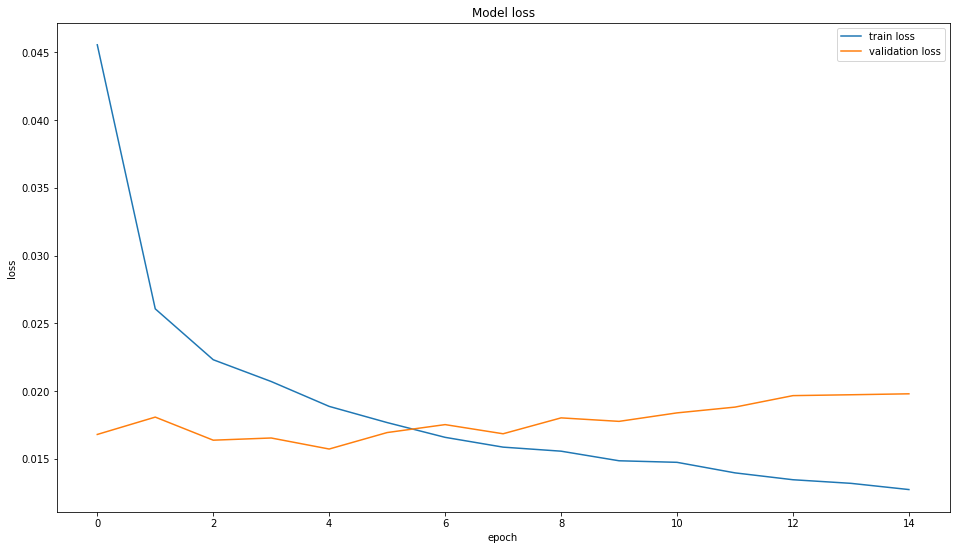

In [157]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [158]:
data.columns

Index(['NO', 'NO2', 'NOx', 'O3', 'Temp'], dtype='object')

In [161]:
  data_val = X_scaler.fit_transform(data[['NO', 'NO2', 'NOx', 'O3', 'Temp']].tail(48))
  val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [162]:
pred = lstm_model.predict(val_rescaled)
pred

array([[0.5641822 , 0.56829137, 0.54661983, 0.5333866 , 0.5176797 ,
        0.49922237, 0.49725097, 0.45647863, 0.44344813, 0.42717886]],
      dtype=float32)

In [163]:
pred_Inverse = Y_scaler.inverse_transform(pred)

In [164]:
pred_Inverse

array([[66.18841 , 66.648636, 64.22142 , 62.7393  , 60.980125, 58.912903,
        58.692112, 54.125603, 52.666187, 50.844032]], dtype=float32)

In [165]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [166]:
pred_Inverse[0]

array([66.18841 , 66.648636, 64.22142 , 62.7393  , 60.980125, 58.912903,
       58.692112, 54.125603, 52.666187, 50.844032], dtype=float32)

In [167]:
timeseries_evaluation_metrics_func(validate['O3'],pred_Inverse[0])

Evaluation metric results:-
MSE is : 1442.4799747800498
MAE is : 35.70187263488769
RMSE is : 37.979994402053954
MAPE is : 227.5422379525759
R2 is : -5.120242584666509



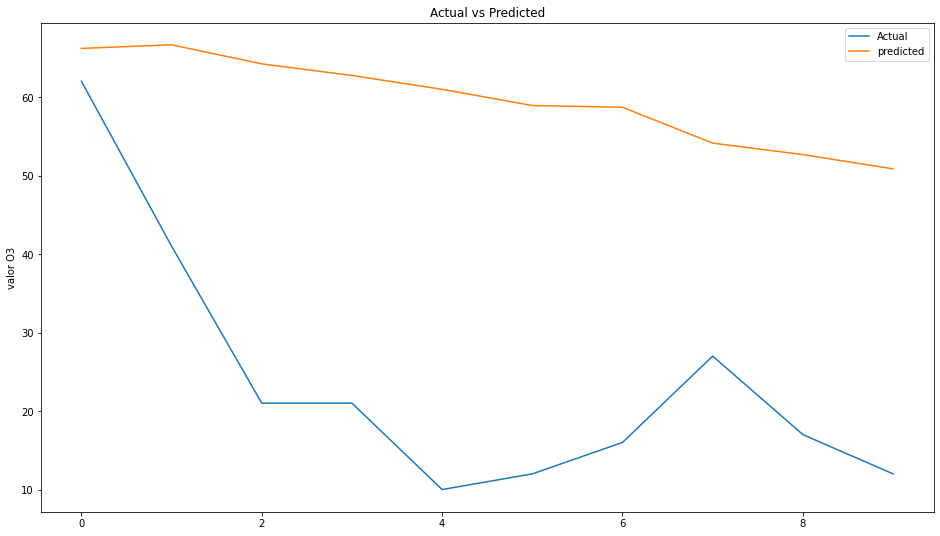

In [168]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['O3']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("valor O3")
plt.legend(('Actual','predicted'))
plt.show()